# SpinLabels on Proteins

In [ ]:
! find . -maxdepth 1 -type f  ! -name "*.ipynb" -delete

In [ ]:
! pip install --pre chilife
! git clone https://github.com/mtessmer/chilife_workshop.git

In [ ]:
cd chilife_workshop

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import chilife as xl

# loading a protein

In [2]:

print(xl.fetch('1ubq', save=True))

ubq = xl.load_protein('1ubq.pdb')



<Universe with 660 atoms>


> NOTE: chiLife also has it's own built in system for handiling protein structures. Currently chiLife primarily uses this system internally, but it can be used the same way MDAnalysis can and may one day replace MDA.

# Labeling a protein

In [3]:
# You can label a protein by passing a residue site and a protein to the xl.SpinLabel constructor
SL1 = xl.SpinLabel('R1M', 28, ubq)
xl.save(SL1)

# If we just save the spin label 
xl.save(SL1, ubq)

# The spin label remembers which protein it was built with
xl.save(SL1, SL1.protein)

* Note that the SpinLabel object is independent of the protein object, the native residue os still there
* If you want to replace the native reside you need to `mutate`

In [ ]:
ubq_A28R1 = xl.mutate(ubq, SL1)
xl.save('ubq_A28R1.pdb', ubq_A28R1)

* Now you can use all your favorite spin label properties to assess this site.
    * You can be looking at spin label conformations or interactinos
    * Asses or fit membrane depths data.
* Most people are primarily interested in distance distribution 
* To calculate a distance distributions we will need to create another spin label

In [4]:
# Second Label
SL2 = xl.SpinLabel('R1M', 68, ubq)


# We also need to choose a distance range over which we want to calculate our distance distribution
r = np.linspace(15, 80, 256) # Angstroms

# Predict the distance distribuion
P = xl.distance_distribution(SL1, SL2, r)


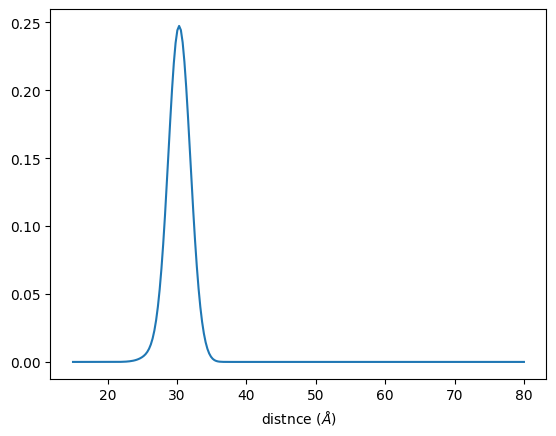

In [5]:
fig, ax = plt.subplots()
ax.plot(r, P)
ax.set_xlabel(r'distnce ($\AA$)')
plt.show()

> NOTE chiLife doesn't care that they are different spin labels. The distance distribution function also doesn't care how many labels we pass it.

* This can be valuble for modeling homooligomers

## Modeling distance distributions from the homotetramer, SthK

* SthK was recently investigate by the former Stoll group member, Eric Evans
* He investigated the and modeled the conformational change of the C-linker domain in response to ligand binding
* SthK's tetrameric nature causes a multimodal distribution:

<img src="https://github.com/mtessmer/chiLife_workshop/blob/main/img/Fig2.1.png?raw=true" style="width: 800px;"/>

* Lets investigate how chiLife handles this

References:

1. Evans, E.G.B., J.L.W. Morgan, F. DiMaio, W.N. Zagotta, and S. Stoll. 2020. Allosteric conformational change of a cyclic nucleotide-gated ion channel revealed by DEER spectroscopy. Proc. Natl. Acad. Sci. USA. 20:10839–10847.
  

In [6]:

# Fetch SthK Cryo-EM structure
SthK = xl.fetch('6cju')

# Now if we just try to label a specific site, chiLife will throw an error because the same site exists on multiple chains
# SL1 = xl.SpinLabel('R1M', 254, SthK) # Trow warning

# Instead we have to add a chain
# SL1 = xl.SpinLabel('R1M', 254, SthK, chain='A')

# Using a for loop we can automate the construction of all four labels
SLs = []
for chain in 'ABCD':

    # And just for fun we can label it with TOAC
    SLs.append(xl.SpinLabel('TOC', 254, SthK, chain=chain))

# We can calculate the distance distribution using the * operator 
P = xl.distance_distribution(*SLs, r)


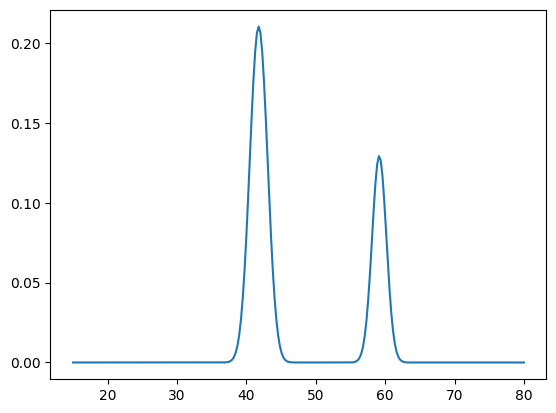

In [7]:
# Plot the predicted distance distributino
fig, ax = plt.subplots()
ax.plot(r, P)
plt.show()

* chiLife conveniently does the math for us.

> NOTE: chiLife does *not* account for multispin artifacts. If you are collecting data from a multispin system artifacts must be accounted for experimentally or in your DEER analysis.

* You may have noticed that these distributions don't quite look like the predicted 2:1 ratio, however this is a consequence of the first peak being broader than the other.
* We can isolate each distnce by using individual sub labels for comparison.  

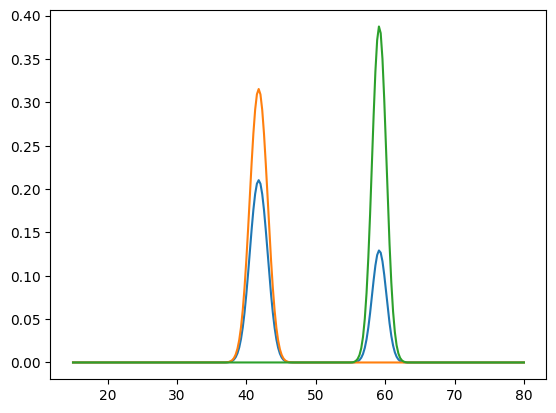

In [8]:
P1 = xl.distance_distribution(SLs[0], SLs[1], r)
P2 = xl.distance_distribution(SLs[0], SLs[2], r)

fig, ax = plt.subplots()
ax.plot(r, P)
ax.plot(r, P1)
ax.plot(r, P2)
plt.show()

Now with these simple tools we can already do a ton of work. 

 * We can write scripts to help us pick sites
 * We can compare experimental data to prediction
 * We can write our own modeling progams
 * We can integrate our analysis into pipelines like PyRosetta. 

# Bifunctional Spin labels


* Now that we have proteins we can also make bifunctional labels.
* bifunctional labels cannot be created without a target protein which is why I did not mention them in the previous section 
* This is because of how the chiLife bifunctional label modeling method works:

<img src="https://github.com/mtessmer/chiLife_workshop/blob/main/img/Fig2.2.png?raw=true" style="width: 800px;"/>

https://youtu.be/so6YlsietO8

* Note that we can check

In [14]:
xl.list_available_rotlibs()


********************************************************************************
*                     Rotlibs in current working directory                     *
********************************************************************************
                                monofunctional:                                 
--------------------------------------------------------------------------------
2CYR_from_traj  : Rotamer library made with chiLife version 1.0.0.dev6 using 
                  `to_rotlib` methodof a rotamer ensemble.
TSP             : None
--------------------------------------------------------------------------------
********************************************************************************
*                     Rotlibs in chilife rotlib directory                      *
********************************************************************************
                                monofunctional:                                 
-----------------------------

In [15]:
dSL1 = xl.dSpinLabel('DCN', [28, 32], ubq)
dSL2 = xl.dSpinLabel('DCN', [66, 68], ubq)


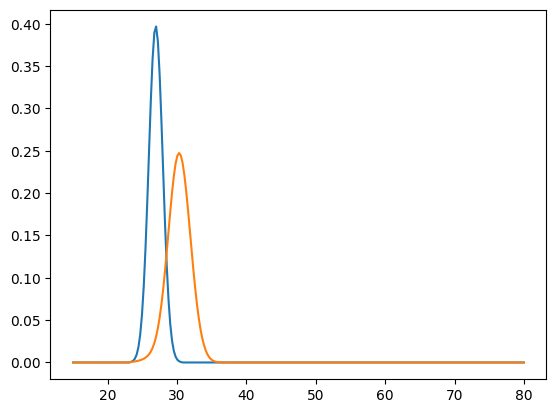

In [16]:
P_DCN = xl.distance_distribution(dSL1, dSL2, r)
P_R1M = xl.distance_distribution(SL1, SL2, r)

plt.plot(r, P_DCN)
plt.plot(r, P_R1M)

In [17]:
xl.save(SL1, SL2, dSL1, dSL2, ubq, write_spin_centers=False)